<a href="https://colab.research.google.com/github/BozidarM/Hand-gestures-classification-with-Pytorch/blob/main/Gestures_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Downloading dataset form kaggle
!mkdir -p /root/.kaggle/
!echo '{"username":"bozidarmladenovic99","key":"4203dd90109ce3f02891cb6e45413b2b"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d tuanai/american-sign-language-dataset

Dataset URL: https://www.kaggle.com/datasets/tuanai/american-sign-language-dataset
License(s): apache-2.0
 92% 26.0M/28.4M [00:02<00:00, 15.1MB/s]
100% 28.4M/28.4M [00:02<00:00, 10.1MB/s]


In [ ]:
filepath = '/content/american-sign-language-dataset.zip'
output_directory = '/content'

!unzip -q {filepath} -d {output_directory}

In [ ]:
#Connecting colab to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Required imports
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import AdamW
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import shutil
import numpy as np
import time

#Parent directory for images
parent_directory = '/content/asl_dataset'
class_list = [
  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]
class_counter = 0;

validation_accuracy_list_small = []
validation_accuracy_list_large = []

validation_loss_list_small = []
validation_loss_list_large = []

train_accuracy_list_small = []
train_accuracy_list_large = []

train_loss_list_small = []
train_loss_list_large = []

best_model_small = '/content/drive/MyDrive/best_model_small.pt'
best_model_large = '/content/drive/MyDrive/best_model_large.pt'

true_labels_small = []
predicted_labels_small = []

true_labels_large = []
predicted_labels_large = []


In [ ]:
#Check device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU {torch.cuda.get_device_name(0)} is available")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU instead")

GPU Tesla T4 is available


In [ ]:
#Geting info about number of folders and files
unordered_class_list = [];
for folder_name in os.listdir(parent_directory):
    folder_path = os.path.join(parent_directory, folder_name)
    if os.path.isdir(folder_path):
        class_counter += 1
        file_count = len(os.listdir(folder_path))
        unordered_class_list.append(folder_name)
        print(f"Folder: {folder_name}\tFiles: {file_count}")
print(f"Number of classes: {class_counter}")

Folder: 1	Files: 70
Folder: i	Files: 70
Folder: f	Files: 70
Folder: e	Files: 70
Folder: l	Files: 70
Folder: m	Files: 70
Folder: k	Files: 70
Folder: p	Files: 70
Folder: v	Files: 70
Folder: 4	Files: 70
Folder: n	Files: 70
Folder: q	Files: 70
Folder: x	Files: 70
Folder: g	Files: 70
Folder: o	Files: 70
Folder: w	Files: 70
Folder: a	Files: 70
Folder: d	Files: 70
Folder: u	Files: 70
Folder: r	Files: 70
Folder: c	Files: 70
Folder: t	Files: 65
Folder: h	Files: 70
Folder: 6	Files: 70
Folder: b	Files: 70
Folder: 0	Files: 70
Folder: j	Files: 70
Folder: y	Files: 70
Folder: s	Files: 70
Folder: 5	Files: 70
Folder: 3	Files: 70
Folder: 7	Files: 70
Folder: z	Files: 70
Folder: 9	Files: 70
Folder: 2	Files: 70
Folder: 8	Files: 70
Number of classes: 36


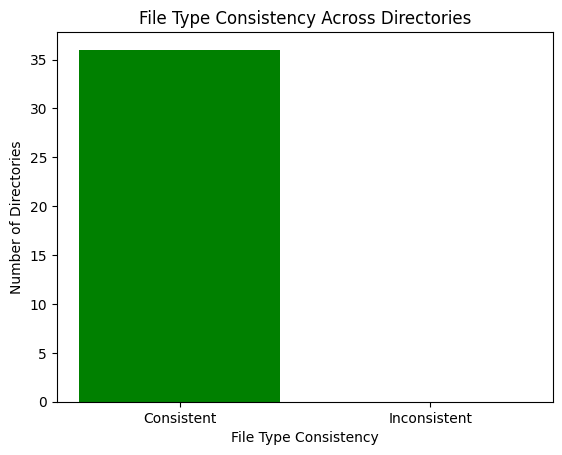

In [ ]:
# Dictionary to store the results of file type checks
file_type_consistency = {}

# Checking file types in each directory
for root, dirs, files in os.walk(parent_directory):
    if root != parent_directory and files:
        first_file_type = os.path.splitext(files[0])[1]
        consistent = True
        for file_name in files:
            file_type = os.path.splitext(file_name)[1]
            if file_type != first_file_type:
                consistent = False
                break

        directory_name = os.path.basename(root)
        if consistent:
            file_type_consistency[directory_name] = "Consistent"
        else:
            file_type_consistency[directory_name] = "Inconsistent"

# Counting the number of consistent and inconsistent directories
consistency_count = {
    "Consistent": list(file_type_consistency.values()).count("Consistent"),
    "Inconsistent": list(file_type_consistency.values()).count("Inconsistent")
}

# Plotting the result as a bar chart
plt.bar(consistency_count.keys(), consistency_count.values(), color=['green', 'red'])
plt.xlabel('File Type Consistency')
plt.ylabel('Number of Directories')
plt.title('File Type Consistency Across Directories')

# Displaying the plot
plt.show()

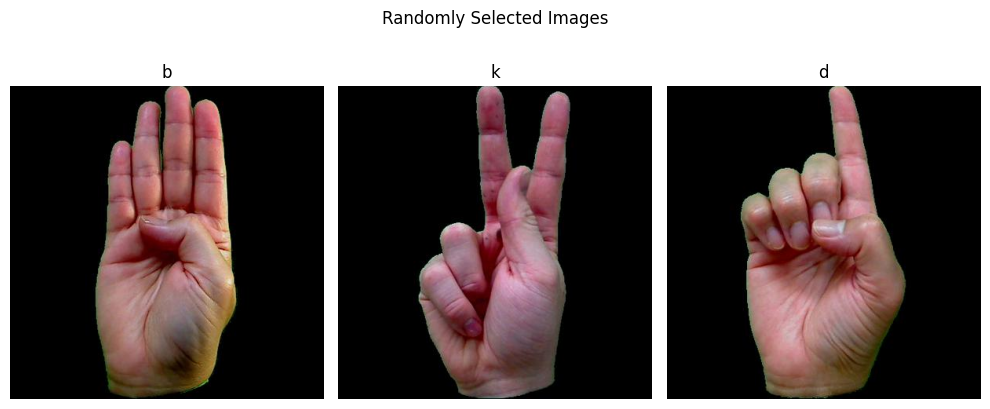

In [ ]:
# Randomly select three different classes
selected_classes = random.sample(class_list, k=3)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 3 columns
fig.suptitle('Randomly Selected Images', fontsize=12)  # Title for the entire figure

# Iterate over the selected classes and choose one random image from each class
for ax, class_name in zip(axes, selected_classes):
    class_directory = os.path.join(parent_directory, class_name)
    image_list = os.listdir(class_directory)
    random_image = random.choice(image_list)
    image_path = os.path.join(class_directory, random_image)

    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(class_name)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=1)  # Adjust the top space to fit the suptitle

# Display the plots
plt.show()

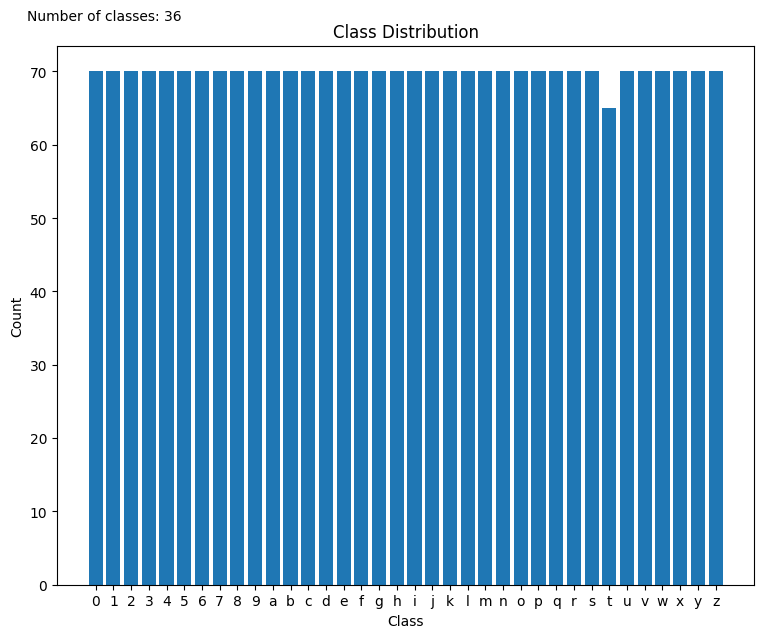

In [ ]:
import os
import matplotlib.pyplot as plt

# Counting the number of images in each class directory
class_counts = {}
for class_name in os.listdir(parent_directory):
    class_directory = os.path.join(parent_directory, class_name)
    if os.path.isdir(class_directory):
        class_counts[class_name] = len(os.listdir(class_directory))

# Sorting the class counts according to the order in class_list
sorted_class_counts = {class_name: class_counts.get(class_name, 0) for class_name in class_list}

# Plotting the bar chart
class_names = list(sorted_class_counts.keys())
class_values = list(sorted_class_counts.values())

plt.figure(figsize=(9, 7))
plt.bar(class_names, class_values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

plt.text(0.5, max(class_values) * 1.10, f"Number of classes: {class_counter}", ha='center', fontsize=10)

# Rotating the x-axis labels if needed
plt.xticks(rotation=360)

# Displaying the plot
plt.show()

print()

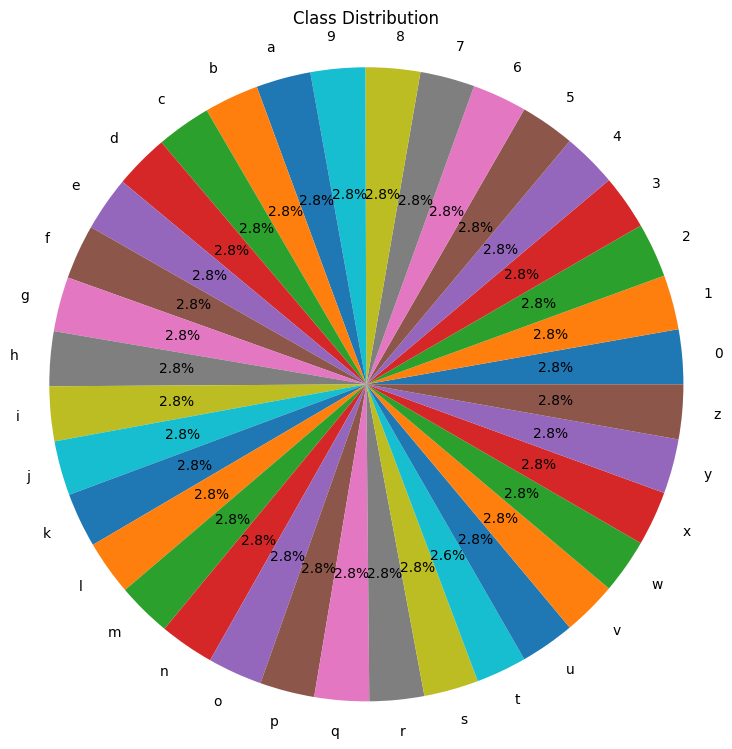

In [ ]:
# Plotting the pie chart
class_names = list(sorted_class_counts.keys())
class_values = list(sorted_class_counts.values())

plt.figure(figsize=(9, 9))
plt.pie(class_values, labels=class_names, autopct='%1.1f%%', textprops={'fontsize': 10})
plt.axis('equal')
plt.title('Class Distribution', pad=10)

# Displaying the plot
plt.show()

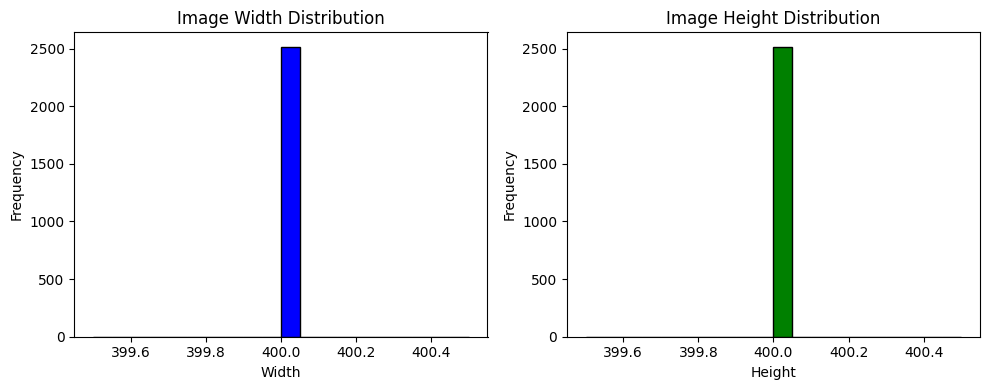

In [ ]:
# Lists to store the widths and heights of images
image_widths = []
image_heights = []

# Iterate over the class directories and collect image dimensions
for class_name in os.listdir(parent_directory):
    class_directory = os.path.join(parent_directory, class_name)
    if os.path.isdir(class_directory):
        for image_name in os.listdir(class_directory):
            image_path = os.path.join(class_directory, image_name)
            if os.path.isfile(image_path):
                image = plt.imread(image_path)
                height, width, _ = image.shape
                image_widths.append(width)
                image_heights.append(height)

# Creating the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Creating the histogram for image widths
ax1.hist(image_widths, bins=20, color='blue', edgecolor='black')
ax1.set_xlabel('Width')
ax1.set_ylabel('Frequency')
ax1.set_title('Image Width Distribution')

# Creating the histogram for image heights
ax2.hist(image_heights, bins=20, color='green', edgecolor='black')
ax2.set_xlabel('Height')
ax2.set_ylabel('Frequency')
ax2.set_title('Image Height Distribution')

# Adjust layout to prevent overlap
plt.tight_layout()

# Displaying the plots
plt.show()

In [ ]:
# Set the random seed for operations
seed = 24
torch.manual_seed(seed)

# Check if CUDA is available and set the random seed for GPU operations
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

Train set size: 1760
Test set size: 377
Validation set size: 378


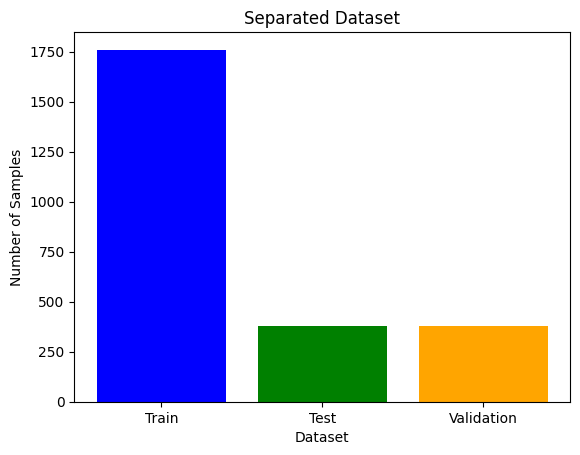

In [ ]:
train_ratio = 0.7  # 70% of the data for training
test_ratio = 0.15  # 15% of the data for testing
valid_ratio = 0.15  # 15% of the data for validation

# Loading the dataset using ImageFolder
dataset = ImageFolder(parent_directory)

# Spliting the dataset into train, test, and validation sets
num_samples = len(dataset)
train_size = int(num_samples * train_ratio)
test_size = int(num_samples * test_ratio)
valid_size = num_samples - train_size - test_size

train_dataset, test_dataset, validation_dataset = random_split(dataset, [train_size, test_size, valid_size])

print("Train set size:", len(train_dataset))
print("Test set size:", len(test_dataset))
print("Validation set size:", len(validation_dataset))

# Dataset labels and sizes
labels = ['Train', 'Test', 'Validation']
sizes = [train_size, test_size, valid_size]

# Create bar plot
plt.bar(labels, sizes, color=['blue', 'green', 'orange'])

# Add title and labels
plt.title('Separated Dataset')
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')

# Show the plot
plt.show()

In [ ]:
# Define the transformations for each set
# Define common base transformation
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Train transformation with augmentations
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop((224,224)),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    *base_transform.transforms,  # Inherit from base
])

# Define batch size for training
batch_size = 64

# Apply transformations to each set
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = base_transform
validation_dataset.dataset.transform = base_transform

# Create DataLoader objects for efficient loading during training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Train Tensor: ')
print(train_dataset[0])

Train Tensor: 
(tensor([[[-2.0665, -2.0665, -2.0665,  ..., -2.1179, -2.1179, -2.1179],
         [-2.0665, -2.0665, -2.0665,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -

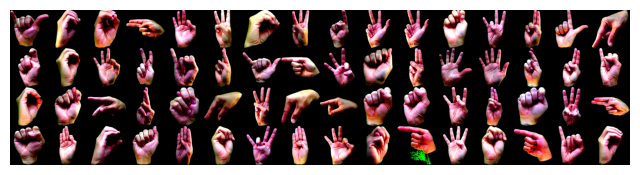

In [ ]:
# Get a batch of images
batch = next(iter(train_loader))

# Extract the images and labels from the batch
images, labels = batch

# Unnormalize the images
unnormalize = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])  # This is for normalizing in the range [0, 1]
images = unnormalize(images)

# Clamp the images to ensure pixel values are in the range [0, 1]
images = torch.clamp(images, 0, 1)

# Create a grid of images
grid = torchvision.utils.make_grid(images, nrow=16)

# Convert the grid tensor to a numpy array
grid = grid.numpy().transpose((1, 2, 0))  # Change tensor dimensions from (C, H, W) to (H, W, C)

# Plot the grid of images, making the figure bigger
plt.figure(figsize=(8, 8))  # Increase the size of the plot
plt.imshow(grid)
plt.axis('off')  # Remove axis for a cleaner display
plt.show()

In [ ]:
#loading model small
model_small = torchvision.models.mobilenet_v3_small(pretrained=True)
#loading model large
model_large = torchvision.models.mobilenet_v3_large(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 143MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are de

In [ ]:
# Remove dropout layers
def remove_dropout(model):
    for module_name, module in model.named_children():
        if isinstance(module, torch.nn.Dropout):
            setattr(model, module_name, torch.nn.Identity())
        else:
            remove_dropout(module)

In [ ]:
def prepare_model(model, class_counter):
    # freezeing the weights of the pre-trained layers
    for param in model.parameters():
        param.requires_grad = False

    # Ensuring the model is suitable for the number of classes in dataset
    num_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_features, class_counter)

    # Moving the model to the GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    if next(model.parameters()).is_cuda:
        print("Model is on GPU")
    else:
        print("Model is on CPU")

    return model, device

In [ ]:
#Evalution function
def evaluate_model(model, val_set, device, validation_accuracy_list, validation_loss_list):

    model.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        hit = 0
        for inputs, labels in val_set:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # number of correct predictions
            predicted = torch.max(outputs.data, 1)[1]
            hit += (predicted == labels).sum()

            # Compute the loss
            loss = F.cross_entropy(outputs, labels)

        accuracy = round(hit.item() * 100 / len(validation_dataset), 2)

        #Saveing train accuracy and loss for each epoch
        validation_accuracy_list.append(accuracy)
        validation_loss_list.append(loss.item())

        print(f"Validation loss: {round(loss.item(), 2)}")
        print(f"Validation accuracy: {accuracy}%")

    return accuracy

In [ ]:
# Train Model
def train_model(model, train_loader, validation_loader, device, class_counter, train_accuracy_list, train_loss_list, validation_accuracy_list, validation_loss_list, model_drive_path):
    # Define the hyperparameter search space
    learning_rates = [0.001]

    num_epoch = 150

    best_loss = 0.0
    best_overall_accuracy = 0.0

    # Track the number of iterations without improvement
    no_improvement = 0
    max_no_improvement = 10  # Maximum number of iterations without improvement

    # Start timing
    start_time = time.time()

    # Perform random search
    for l_r in learning_rates:
        learning_rate = l_r

        print(f"Current Learning Rate: {l_r}")

        # Create the model and optimizer with sampled hyperparameters
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

        # Train the model
        criterion = nn.CrossEntropyLoss()

        for epoch in range(num_epoch):
          model.train()
          hit = 0
          for images, labels in train_loader:
              images = images.to(device)
              labels = labels.to(device)

              # Forward pass
              outputs = model(images)
              loss = criterion(outputs, labels)

              # number of correct predictions
              predicted = torch.max(outputs.data, 1)[1]
              hit += (predicted == labels).sum()

              # Backward pass and optimization
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

          # Evaluate the model on the validation set
          validation_accuracy = evaluate_model(model, validation_loader, device, validation_accuracy_list, validation_loss_list)

          # Check if the validation loss improved
          if validation_accuracy > best_overall_accuracy:
              best_overall_accuracy = validation_accuracy
              no_improvement = 0

              torch.save(model.state_dict(), model_drive_path)
          else:
              no_improvement += 1

          # Check for early stopping
          if no_improvement >= max_no_improvement:
              print("Early stopping: No improvement in validation accuracy.")
              break

          accuracy = round(hit.item() * 100 / len(train_dataset), 2)

          #Saveing train accuracy and loss for each epoch
          train_accuracy_list.append(accuracy)
          train_loss_list.append(loss.item())

          print("Epoch: ", epoch + 1)
          print(f"Train loss: {round(loss.item(), 2)}")
          print(f"Train accuracy: {accuracy}%")

    # End timing
    end_time = time.time()
    training_duration = end_time - start_time

    # Convert to hours, minutes, and seconds
    hours = int(training_duration // 3600)
    minutes = int((training_duration % 3600) // 60)
    seconds = int(training_duration % 60)

    # Format the time string based on whether hours are needed
    if hours > 0:
        time_string = f"{hours}:{minutes}:{seconds}"
    else:
        time_string = f"{minutes}:{seconds}"

    # Print the formatted training duration
    print(f"Train time needed: {time_string}")

In [ ]:
model_small, device_small = prepare_model(model_small, class_counter)

model_small

Model is on GPU


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
# Train and evaluate MobileNetV3 Small
print("Training MobileNetV3 Small")
train_model(
    model_small,
    train_loader,
    validation_loader,
    device_small,
    class_counter,
    train_accuracy_list_small,
    train_loss_list_small,
    validation_accuracy_list_small,
    validation_loss_list_small,
    best_model_small
)

Training MobileNetV3 Small
Current Learning Rate: 0.001
Validation loss: 3.13
Validation accuracy: 29.89%
Epoch:  1
Train loss: 2.49
Train accuracy: 32.73%
Validation loss: 2.45
Validation accuracy: 42.59%
Epoch:  2
Train loss: 1.71
Train accuracy: 79.49%
Validation loss: 2.01
Validation accuracy: 52.65%
Epoch:  3
Train loss: 1.25
Train accuracy: 87.33%
Validation loss: 1.67
Validation accuracy: 60.32%
Epoch:  4
Train loss: 0.97
Train accuracy: 90.8%
Validation loss: 1.37
Validation accuracy: 66.93%
Epoch:  5
Train loss: 0.78
Train accuracy: 92.67%
Validation loss: 1.12
Validation accuracy: 73.28%
Epoch:  6
Train loss: 0.67
Train accuracy: 93.47%
Validation loss: 0.91
Validation accuracy: 78.84%
Epoch:  7
Train loss: 0.57
Train accuracy: 94.15%
Validation loss: 0.75
Validation accuracy: 84.13%
Epoch:  8
Train loss: 0.5
Train accuracy: 95.0%
Validation loss: 0.63
Validation accuracy: 88.62%
Epoch:  9
Train loss: 0.42
Train accuracy: 95.85%
Validation loss: 0.54
Validation accuracy: 89.6

In [ ]:
model_large, device_large = prepare_model(model_large, class_counter)

model_large

Model is on GPU


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
# Train and evaluate MobileNetV3 Large
print("Training MobileNetV3 Large")
train_model(
    model_large,
    train_loader,
    validation_loader,
    device_large,
    class_counter,
    train_accuracy_list_large,
    train_loss_list_large,
    validation_accuracy_list_large,
    validation_loss_list_large,
    best_model_large
)

Training MobileNetV3 Large
Current Learning Rate: 0.001
Validation loss: 3.15
Validation accuracy: 17.2%
Epoch:  1
Train loss: 2.22
Train accuracy: 42.39%
Validation loss: 2.74
Validation accuracy: 39.42%
Epoch:  2
Train loss: 1.37
Train accuracy: 85.0%
Validation loss: 2.26
Validation accuracy: 54.5%
Epoch:  3
Train loss: 0.9
Train accuracy: 90.91%
Validation loss: 1.76
Validation accuracy: 65.87%
Epoch:  4
Train loss: 0.67
Train accuracy: 93.41%
Validation loss: 1.34
Validation accuracy: 76.46%
Epoch:  5
Train loss: 0.49
Train accuracy: 95.06%
Validation loss: 1.03
Validation accuracy: 82.28%
Epoch:  6
Train loss: 0.38
Train accuracy: 96.02%
Validation loss: 0.79
Validation accuracy: 84.92%
Epoch:  7
Train loss: 0.31
Train accuracy: 96.93%
Validation loss: 0.64
Validation accuracy: 88.1%
Epoch:  8
Train loss: 0.27
Train accuracy: 97.22%
Validation loss: 0.53
Validation accuracy: 91.01%
Epoch:  9
Train loss: 0.23
Train accuracy: 98.47%
Validation loss: 0.46
Validation accuracy: 93.65%

In [ ]:
def plot_train_val_metrics(model_name, train_accuracy_list, validation_accuracy_list, train_loss_list, validation_loss_list):
  epochs = range(1, len(train_accuracy_list) + 1)

  if len(train_accuracy_list) < len(validation_accuracy_list):
    validation_accuracy_list.pop()

  # Plot train and validation accuracy
  plt.figure(figsize=(15, 10))
  plt.plot(epochs, train_accuracy_list, 'r', label='Train Accuracy')
  plt.plot(epochs, validation_accuracy_list, 'b', label='Validation Accuracy')
  plt.title('Train and Validation Accuracy ' + model_name)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  if len(train_loss_list) < len(validation_loss_list):
    validation_loss_list.pop()

  # Plot train and validation loss
  plt.figure(figsize=(15, 10))
  plt.plot(epochs, train_loss_list, 'r', label='Train Loss')
  plt.plot(epochs, validation_loss_list, 'b', label='Validation Loss')
  plt.title('Train and Validation Loss ' + model_name)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

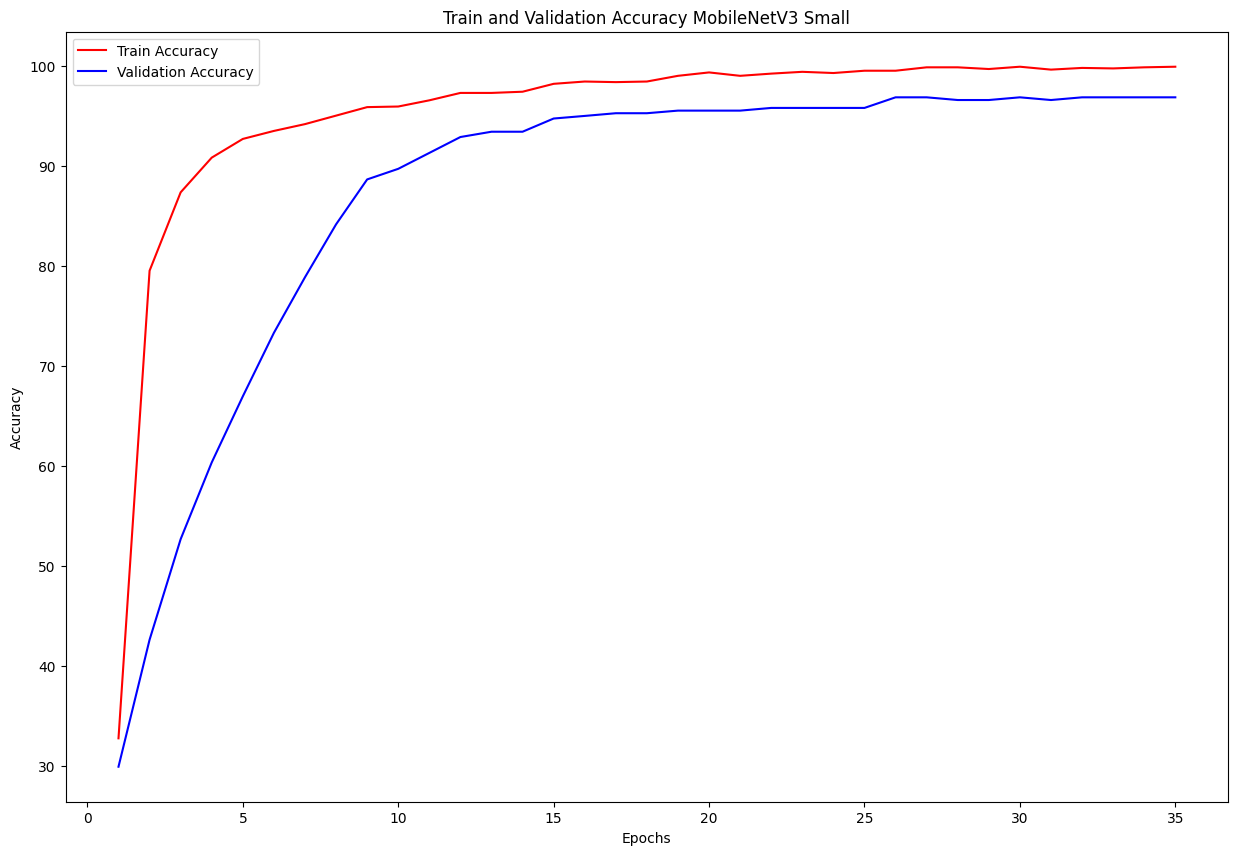

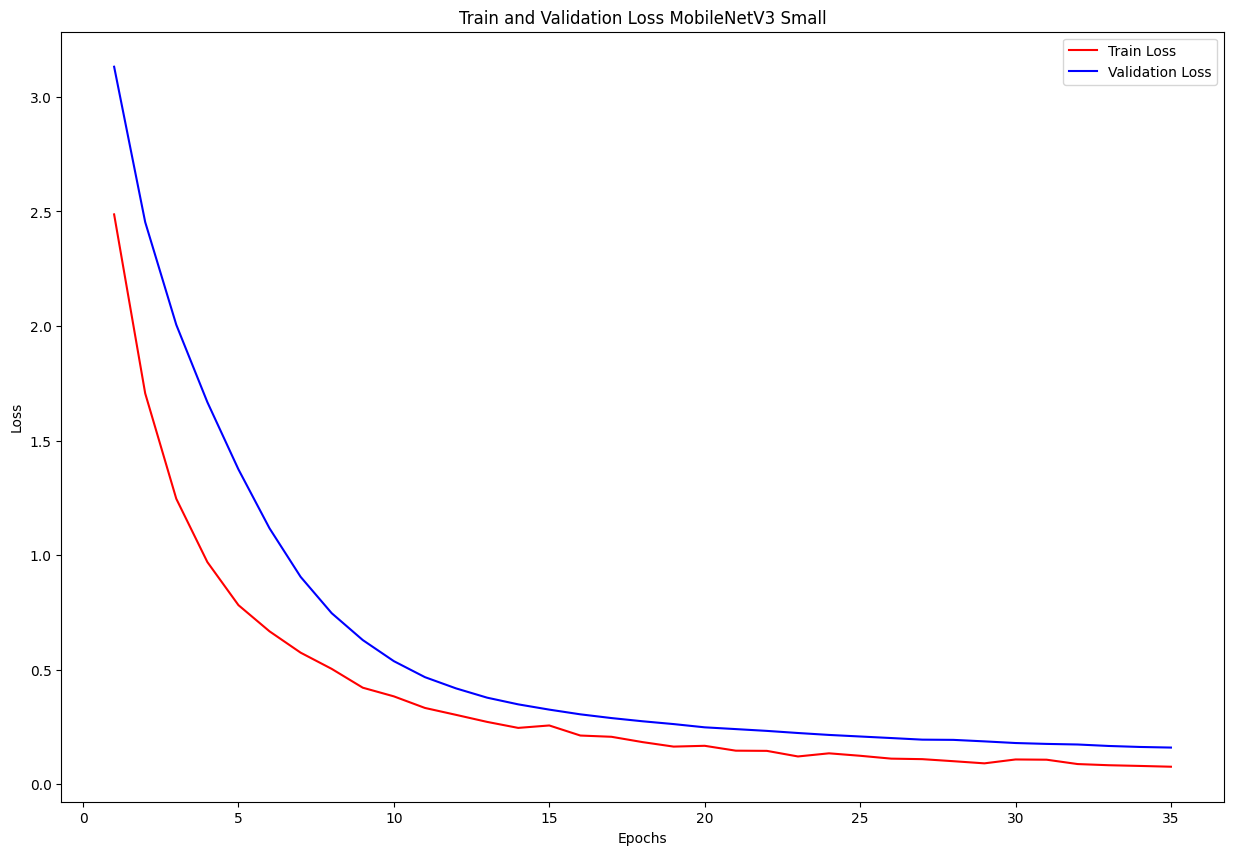

In [ ]:
plot_train_val_metrics("MobileNetV3 Small", train_accuracy_list_small, validation_accuracy_list_small, train_loss_list_small, validation_loss_list_small)

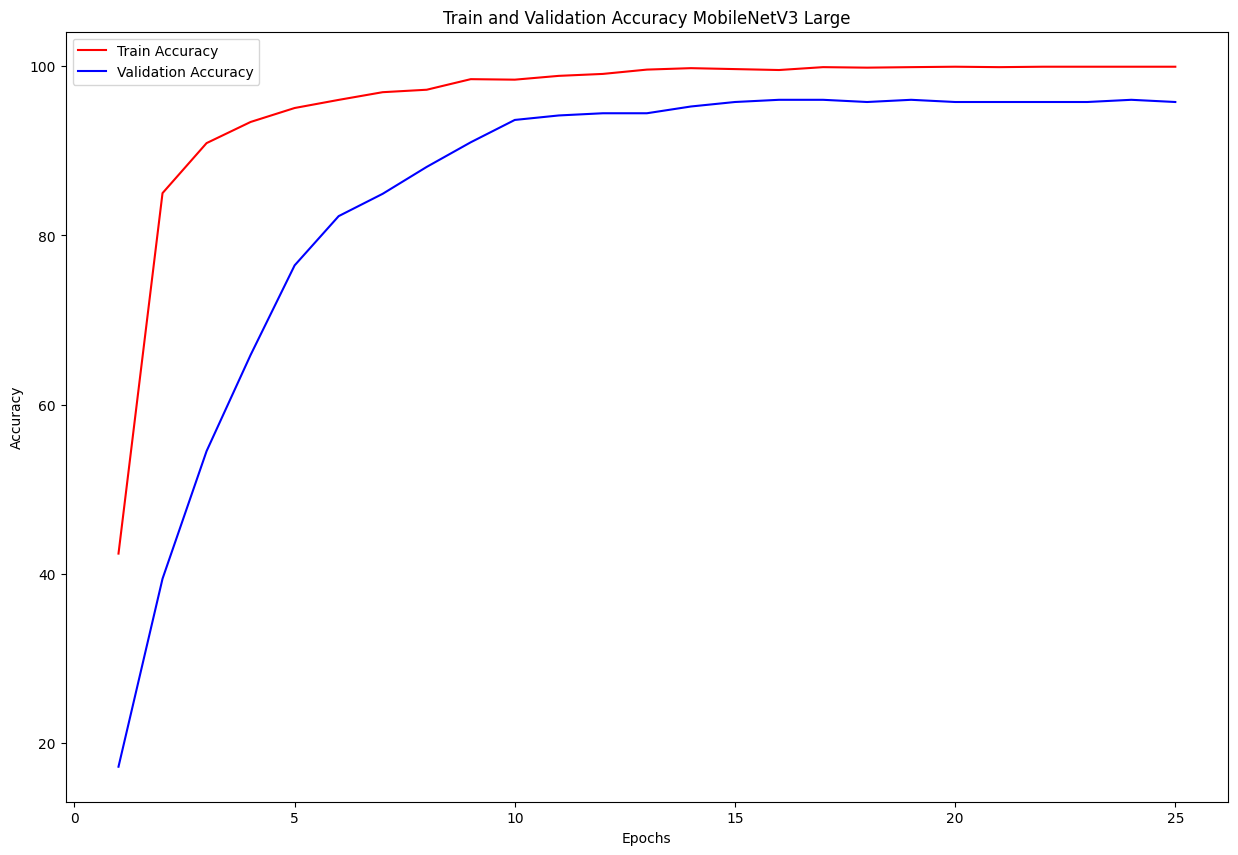

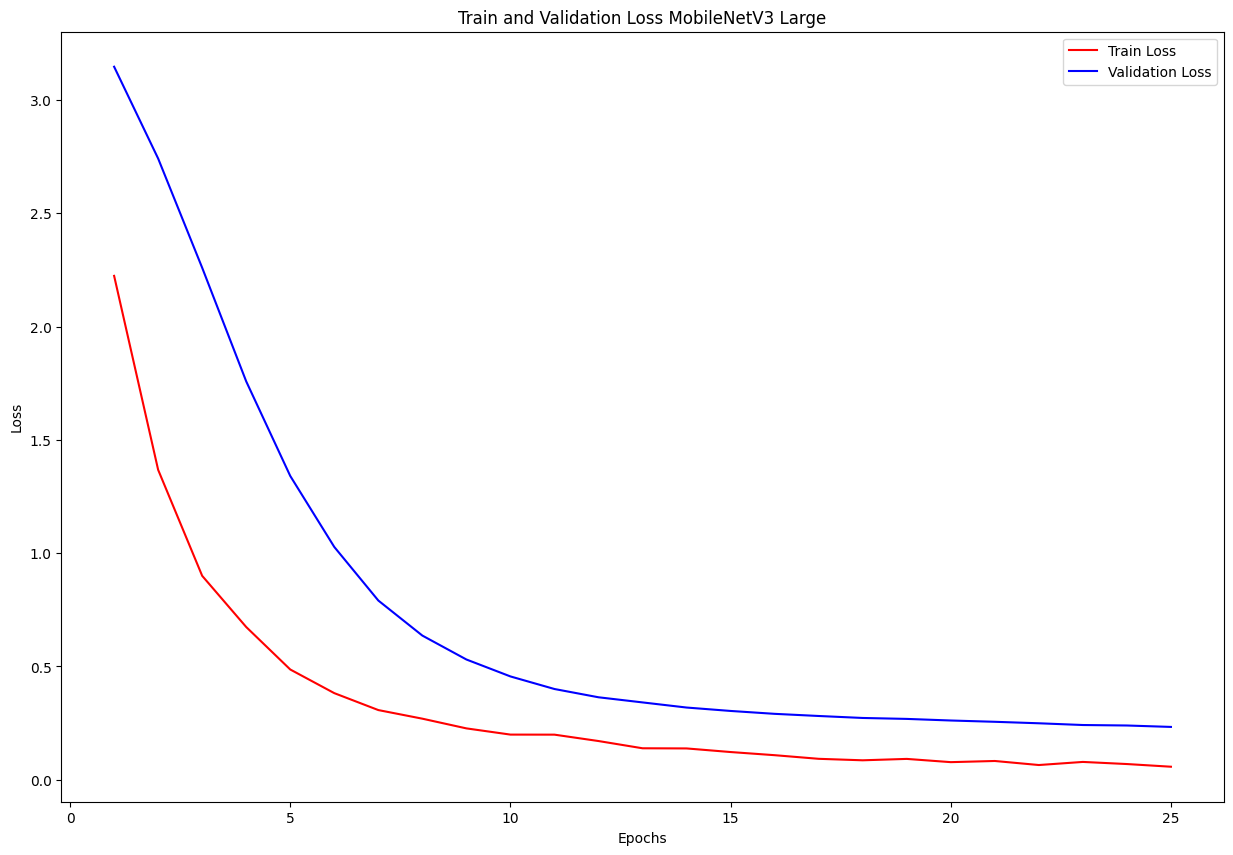

In [ ]:
plot_train_val_metrics("MobileNetV3 Large", train_accuracy_list_large, validation_accuracy_list_large, train_loss_list_large, validation_loss_list_large)

In [ ]:
#Test the model
def test_model(model, test_loader, true_labels, predicted_labels, device):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print('Test Accuracy: {:.2f}%'.format(accuracy * 100))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 Score: {:.2f}'.format(f1))

In [ ]:
model_small.load_state_dict(torch.load(best_model_small))

# Test MobileNetV3 Small
print("Testing MobileNetV3 Small")
test_model(model_small, test_loader, true_labels_small, predicted_labels_small, device_small)

<ipython-input-35-c9466a402ef7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_small.load_state_dict(torch.load(best_model_small))


Testing MobileNetV3 Small
Test Accuracy: 98.14%
Precision: 0.98
Recall: 0.98
F1 Score: 0.98


In [ ]:
model_large.load_state_dict(torch.load(best_model_large))

# Test MobileNetV3 Large
print("Testing MobileNetV3 Large")
test_model(model_large, test_loader, true_labels_large, predicted_labels_large, device_large)

<ipython-input-36-922e0348f899>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_large.load_state_dict(torch.load(best_model_large))


Testing MobileNetV3 Large
Test Accuracy: 97.35%
Precision: 0.98
Recall: 0.97
F1 Score: 0.97


In [ ]:
# Plot the confusion matrix
def plot_confusion_matrix(model_name, true_labels, predicted_labels, class_list):
    c_m = confusion_matrix(true_labels, predicted_labels)
    dataFrame = pd.DataFrame(c_m, class_list, class_list)

    plt.figure(figsize = (9,6))
    sn.heatmap(dataFrame, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show();

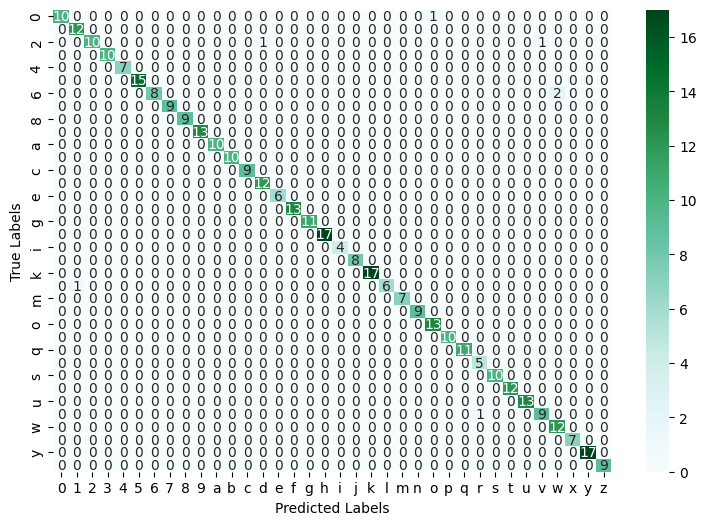

In [ ]:
plot_confusion_matrix("MobileNetV3 Small", true_labels_small, predicted_labels_small, class_list)

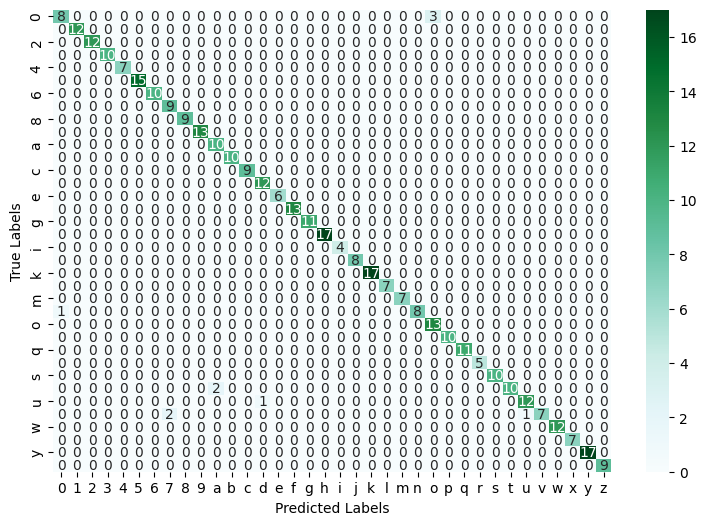

In [ ]:
plot_confusion_matrix("MobileNetV3 Large", true_labels_large, predicted_labels_large, class_list)

In [ ]:
def get_probabilities_and_prediction(model, image_path, class_names):
    model.eval()  # Set the model to evaluation mode

    input_image = base_transform(Image.open(image_path).convert('RGB'))

    # Move image to the device
    image = input_image.to(device)

    with torch.no_grad():
        # Forward pass
        outputs = model(image.unsqueeze(0))  # Add batch dimension

        # Get probabilities
        probabilities = F.softmax(outputs, dim=1)

    # Convert to numpy and return
    return probabilities.cpu().numpy().flatten() * 100

In [ ]:
def plot_probabilities(class_names, probabilities):

    # Plot probabilities
    plt.figure(figsize=(20, 10))
    plt.bar(np.arange(len(class_names)), probabilities, color='blue')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=90, fontsize=15)
    plt.ylabel('Probability', fontsize = 15)
    plt.title('Class Probabilities', fontsize = 20)
    plt.ylim(0, 100)

     # Format y-axis labels to show percentages
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))

    plt.show()

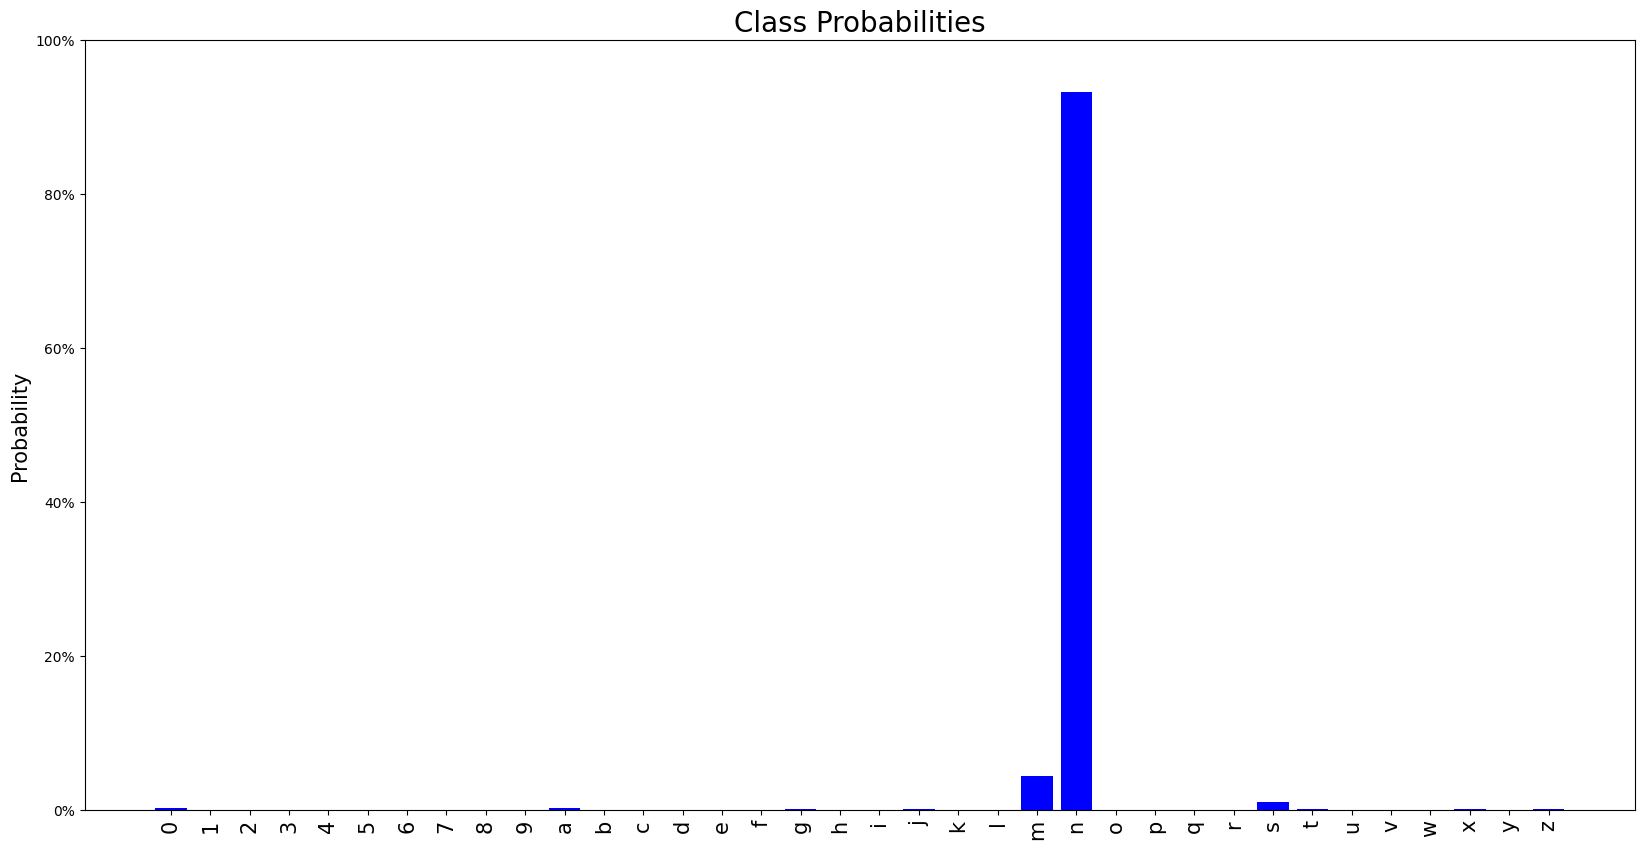

Highest Probability: 93.22000122070312% - Class: n


In [ ]:
url = "/content/asl_dataset/n/hand1_n_bot_seg_1_cropped.jpeg"
# random_image = Image.open(image_path)

probs = get_probabilities_and_prediction(model_small, url, class_list)
plot_probabilities(class_list, probs)

# Find the highest probability and corresponding class
max_prob = max(probs)  # Get the highest probability
predicted_class = class_names[np.argmax(probs)]  # Get the corresponding class name

# Print the highest percentage and class name
print(f"Highest Probability: {np.round(max_prob, 2)}% - Class: {predicted_class}")

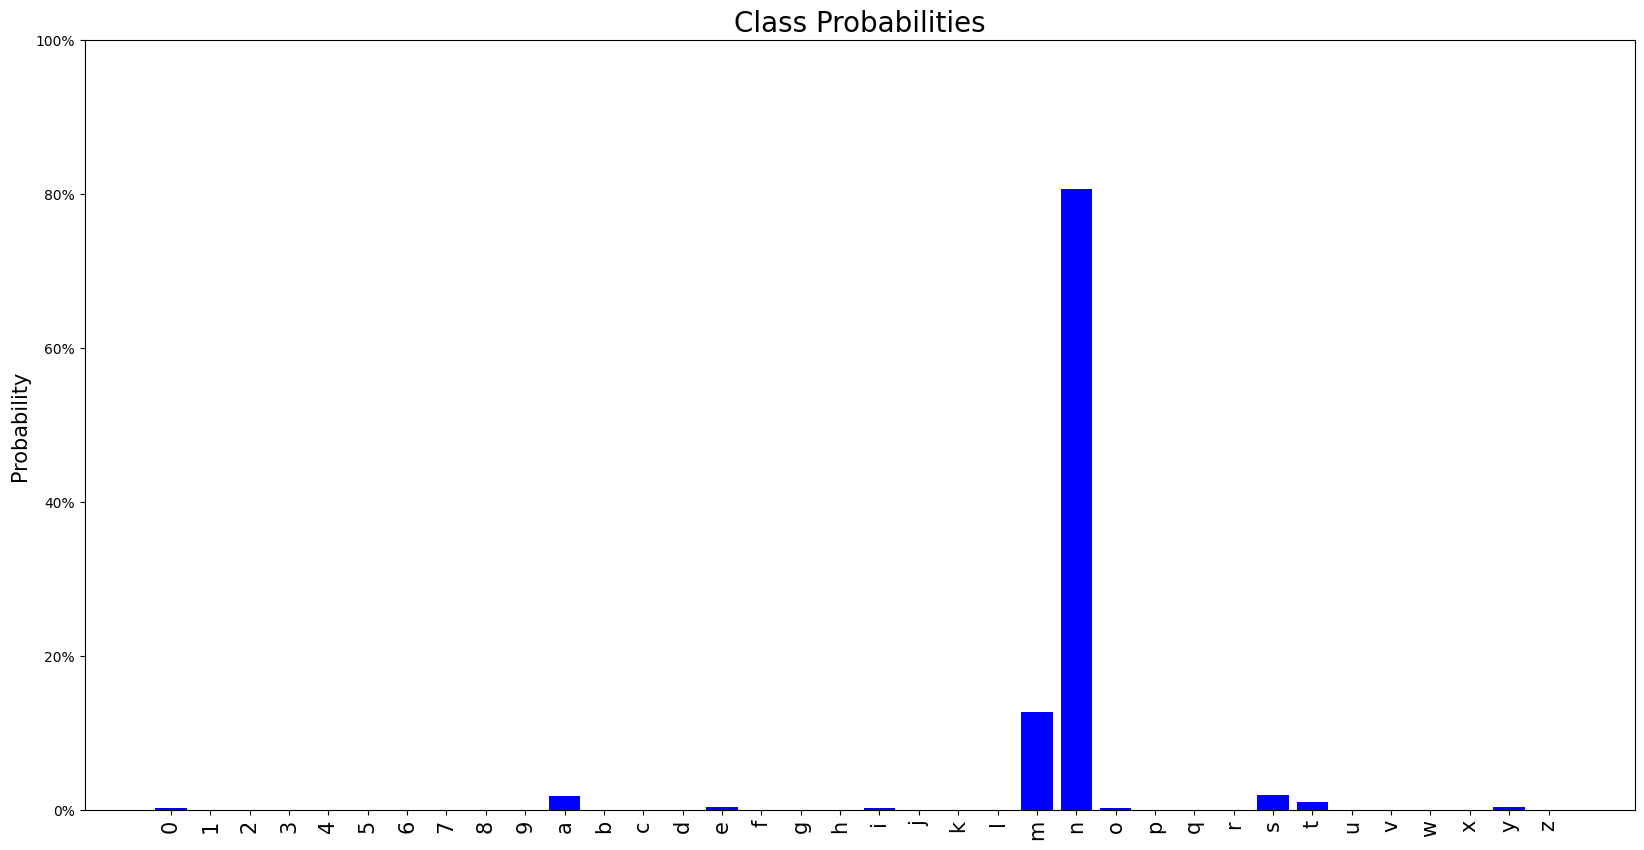

Highest Probability: 80.62805938720703% - Class: n


In [ ]:
url = "/content/asl_dataset/n/hand1_n_bot_seg_1_cropped.jpeg"
# random_image = Image.open(image_path)

probs = get_probabilities_and_prediction(model_large, url, class_list)
plot_probabilities(class_list, probs)

# Find the highest probability and corresponding class
max_prob = max(probs)  # Get the highest probability
predicted_class = class_names[np.argmax(probs)]  # Get the corresponding class name

# Print the highest percentage and class name
print(f"Highest Probability: {max_prob}% - Class: {predicted_class}")

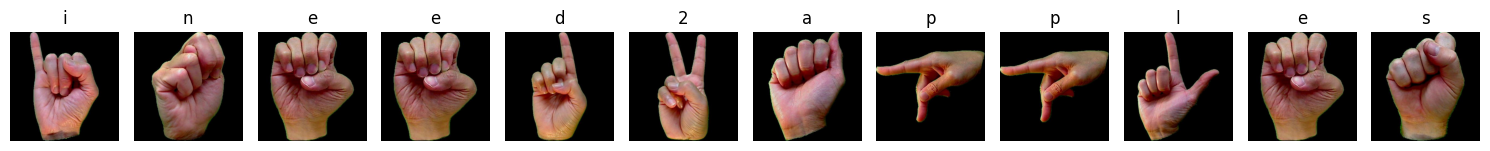

In [ ]:
def get_image_for_letter(letter, model, class_list):
    # Generate the image path based on the letter
    # Assuming each letter has its corresponding image, modify as necessary
    image_path = f"/content/asl_dataset/{letter.lower()}/"

    # List all files in the directory
    files = os.listdir(image_path)

    # Filter for image files
    image_files = [f for f in files if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Get the filename of the first image
    first_image_filename = image_files[0]

    # Create the full path of the first image
    first_image_path = os.path.join(image_path, first_image_filename)

    # Get the predicted class name
    probs = get_probabilities_and_prediction(model_small, first_image_path, class_list)
    predicted_class_name = class_list[np.argmax(probs)]

    # Load the image
    image = Image.open(first_image_path)

    # Return the image and its predicted class name
    return image, predicted_class_name

# The sentence you want to visualize
sentence = "I need 2 apples"

# Container to store images and class names
images = []
class_names = []

# Loop through each letter in the sentence
for letter in sentence:
    # Skip spaces in the sentence
    if letter == " ":
        continue

    image, predicted_class_name = get_image_for_letter(letter, model_small, class_list)
    images.append(image)
    class_names.append(predicted_class_name)

# Display the sequence of images with corresponding class names
plt.figure(figsize=(15, 5))  # Adjust the figure size as necessary

for i, (image, class_name) in enumerate(zip(images, class_names)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(image)
    plt.title(f"{class_name}")
    plt.axis("off")
    plt.tight_layout()

plt.show()